In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataser & Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("data/test", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [4]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [6]:
from jcopdl.layers import conv_block, linear_block

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation="lsoftmax")

        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [11]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Traning Preparation -> MCOC

In [13]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, outdir="model")

# Training

In [12]:
from tqdm.auto import tqdm

In [14]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()

    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6934 | Test_cost  = 0.6910 | Train_score = 0.5240 | Test_score = 0.5000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6863 | Test_cost  = 0.6698 | Train_score = 0.5460 | Test_score = 0.6850 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6521 | Test_cost  = 0.6063 | Train_score = 0.6380 | Test_score = 0.6875 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5804 | Test_cost  = 0.5469 | Train_score = 0.7150 | Test_score = 0.7200 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5298 | Test_cost  = 0.4984 | Train_score = 0.7550 | Test_score = 0.7350 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4640 | Test_cost  = 0.4589 | Train_score = 0.7870 | Test_score = 0.8000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4511 | Test_cost  = 0.4018 | Train_score = 0.7890 | Test_score = 0.8375 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4458 | Test_cost  = 0.3743 | Train_score = 0.7960 | Test_score = 0.8550 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4172 | Test_cost  = 0.3734 | Train_score = 0.8180 | Test_score = 0.8500 |
==> EarlyStop patience =  1 | Best test_score: 0.8550


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4020 | Test_cost  = 0.3537 | Train_score = 0.8140 | Test_score = 0.8475 |
==> EarlyStop patience =  2 | Best test_score: 0.8550


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4025 | Test_cost  = 0.3588 | Train_score = 0.8230 | Test_score = 0.8425 |
==> EarlyStop patience =  3 | Best test_score: 0.8550


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3803 | Test_cost  = 0.3492 | Train_score = 0.8280 | Test_score = 0.8625 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3679 | Test_cost  = 0.3670 | Train_score = 0.8350 | Test_score = 0.8450 |
==> EarlyStop patience =  1 | Best test_score: 0.8625


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3644 | Test_cost  = 0.3705 | Train_score = 0.8370 | Test_score = 0.8425 |
==> EarlyStop patience =  2 | Best test_score: 0.8625


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3662 | Test_cost  = 0.3508 | Train_score = 0.8370 | Test_score = 0.8450 |
==> EarlyStop patience =  3 | Best test_score: 0.8625


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3847 | Test_cost  = 0.3473 | Train_score = 0.8320 | Test_score = 0.8575 |
==> EarlyStop patience =  4 | Best test_score: 0.8625


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3512 | Test_cost  = 0.3462 | Train_score = 0.8460 | Test_score = 0.8450 |
==> EarlyStop patience =  5 | Best test_score: 0.8625
==> Execute Early Stopping at epoch: 17 | Best test_score: 0.8625
==> Best model is saved at model


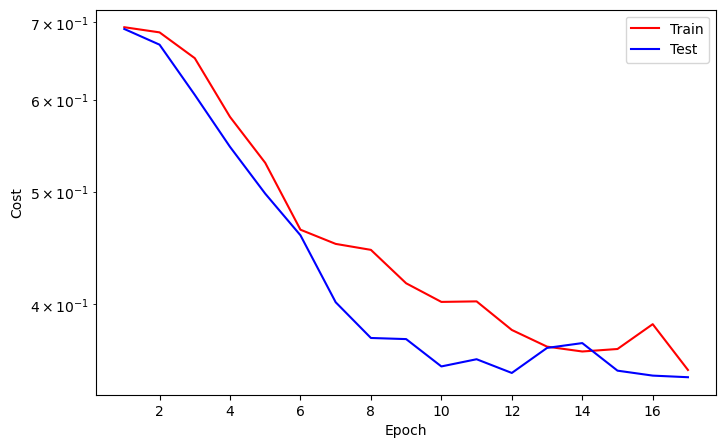

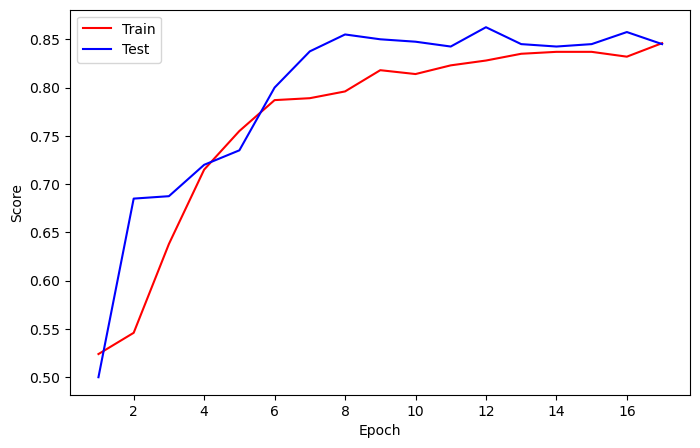

In [15]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [16]:
import matplotlib.pyplot as plt

In [17]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

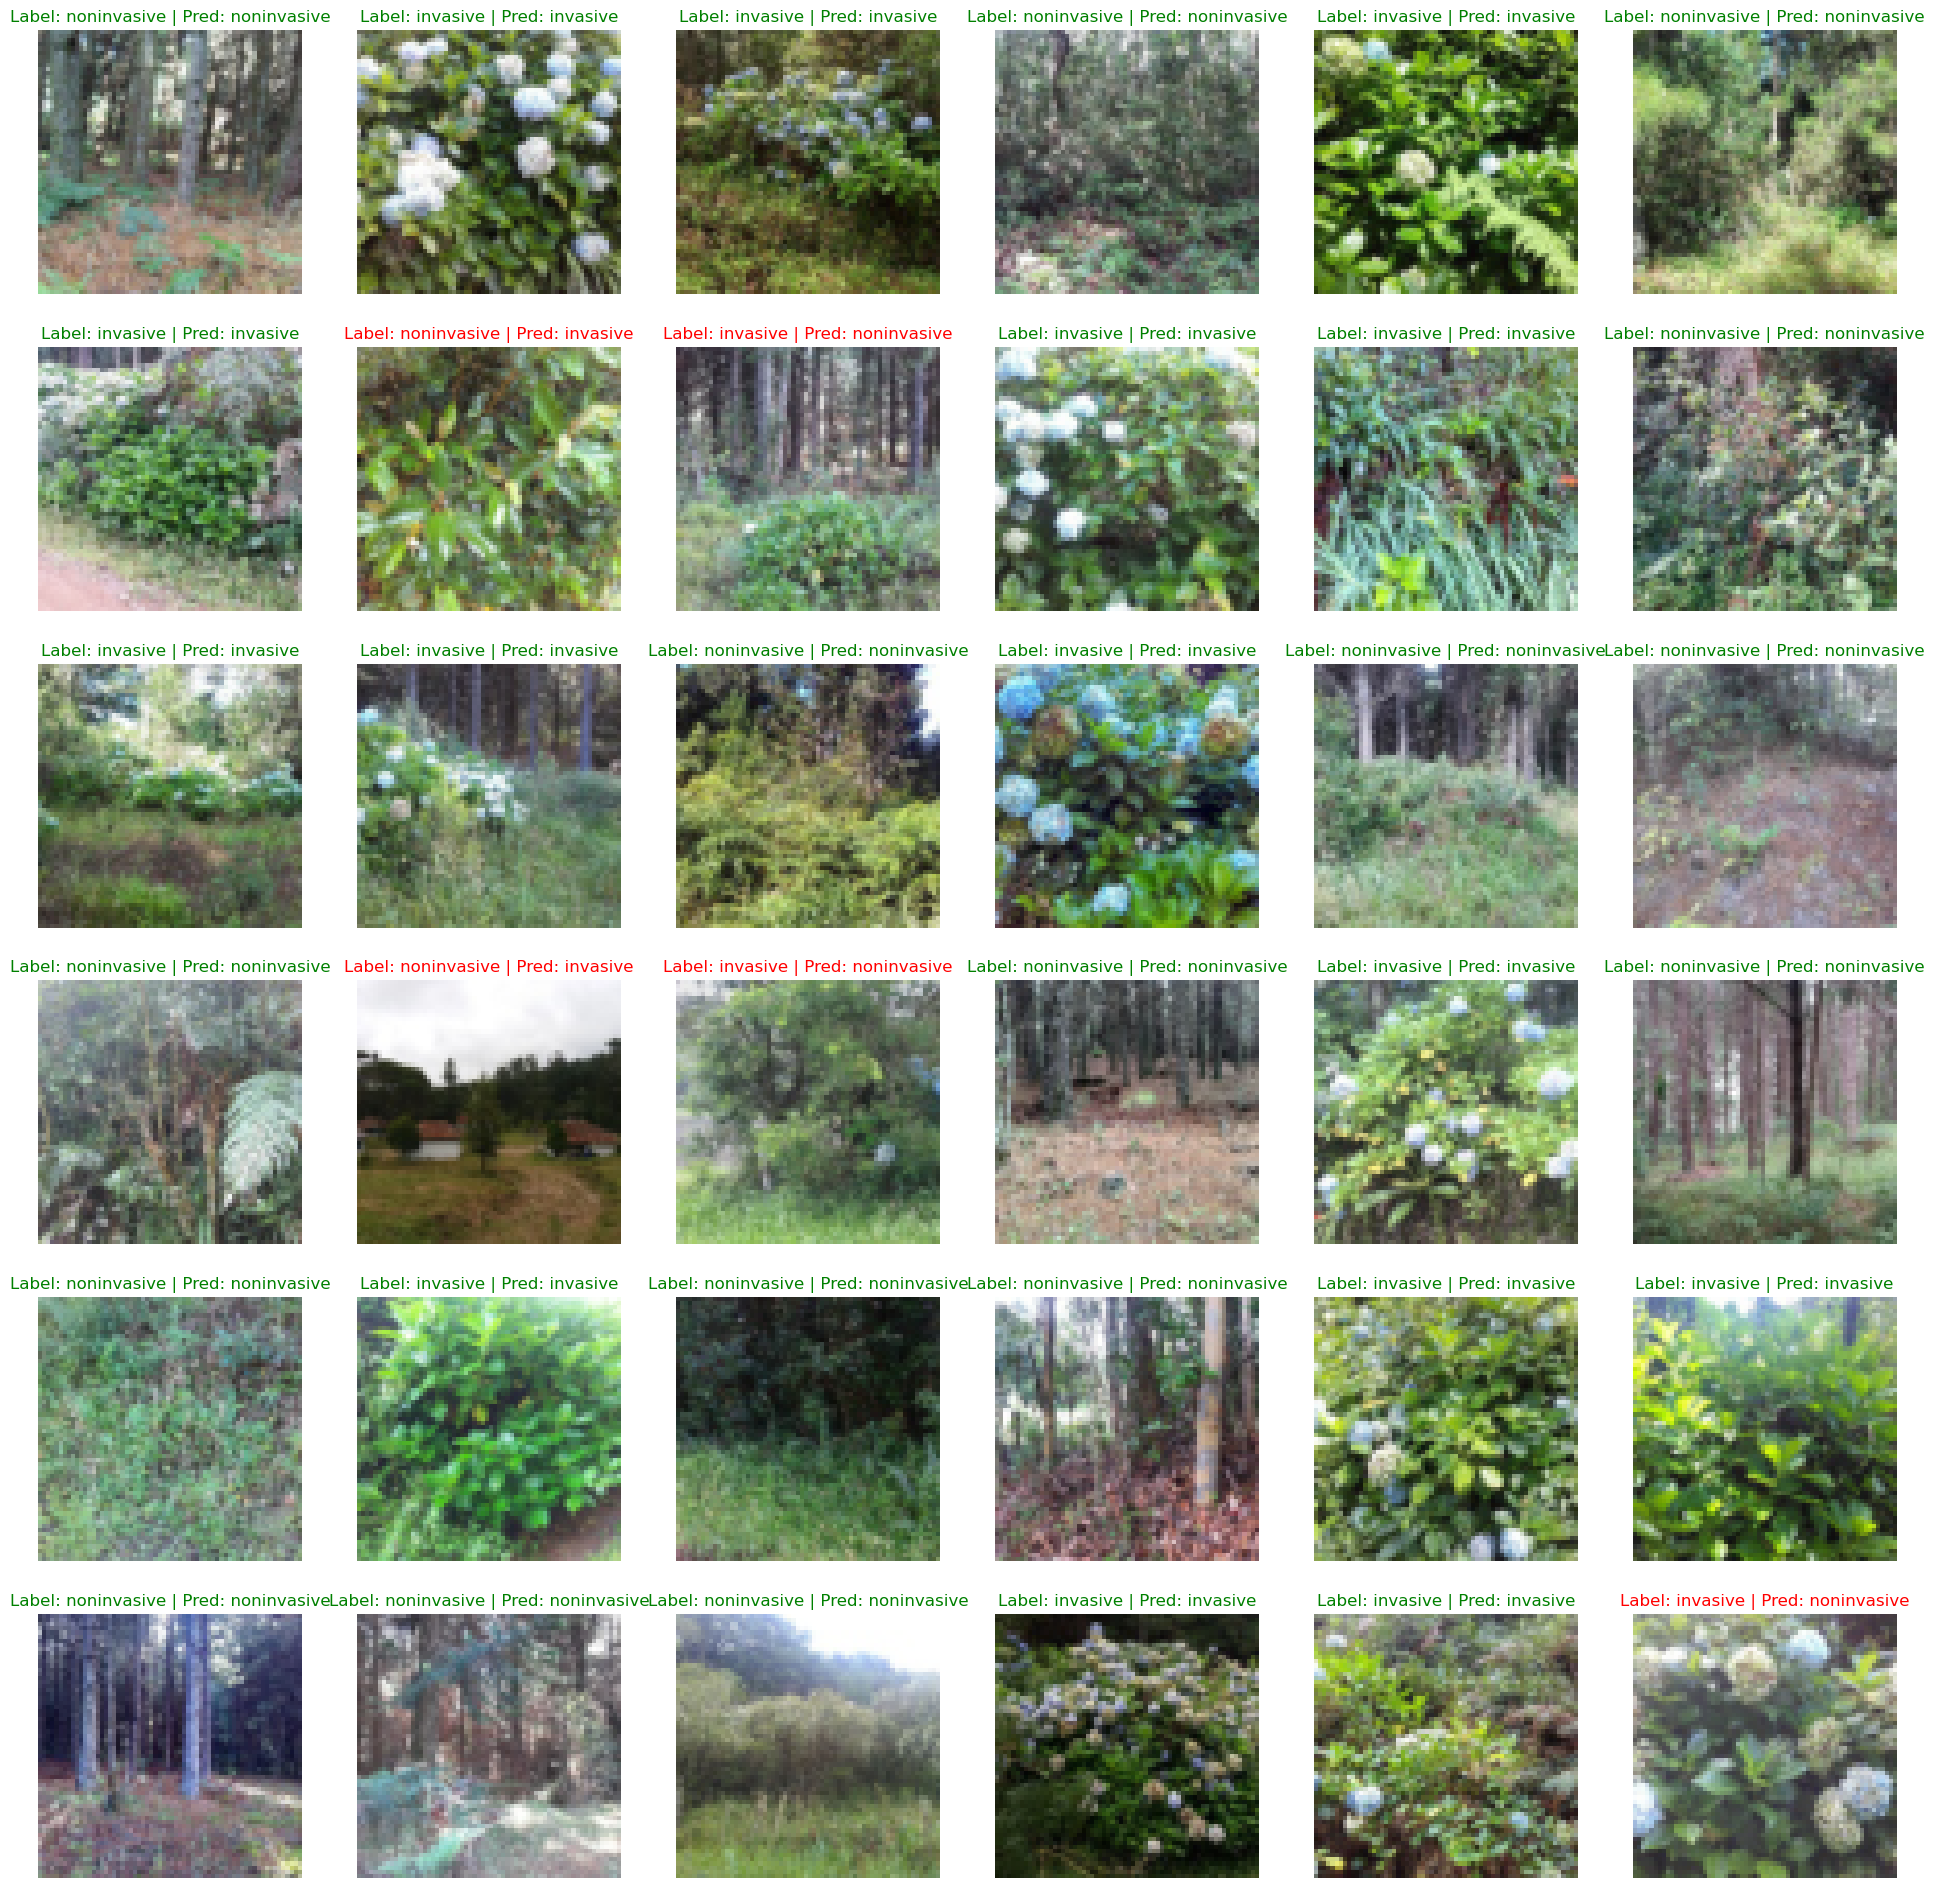

In [18]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font)
    ax.axis('off')